In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2
from local_settings import hostname, username, password, port, database

In [3]:
connection = psycopg2.connect(
            host=hostname, user=username, 
            password=password, dbname=database, 
            port=port
        )

In [4]:
sql_query = "SELECT * FROM data_row"

df = pd.read_sql_query(sql_query, connection)

connection.close()
print(df.shape)
df.head(3)

(26912, 19)


,title,address,price,area,bath,room,property_type,description,year,parking,near_cc,near_school,near_parks,near_avenue,security,elevator,rest_area,pool,web
0,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",120375,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
1,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",119277,45,2,3,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania
2,Proyecto inmobilario en venta en Calle Coronel...,"Calle Coronel Odriozola 128, San IsidroLima, Lima",162297,60,2,2,Departamento,Mozz se deriva de la palabra en italiano mozio...,2023,1,1,0,1,0,0,0,1,0,Urbania


In [5]:
outhome = ['Casa de playa', 'Casa de campo', 'Habitación']
mask = df['property_type'].apply(lambda x: x not in outhome)
df = df[mask]
df.shape

(26560, 19)

In [6]:
df['property_type'] = df['property_type'].str.replace('Apartamento', 'Departamento')
df['property_type'].value_counts()

Departamento    19226
Casa             7334
Name: property_type, dtype: int64

In [7]:
id_mansion = df['title'].apply(lambda x: x.lower()).str.extract('((vend\w* edificio|hotel|hostel|mansion|mansión|hostal).*)').dropna().index
df = df.drop(index=id_mansion)
df.shape

(26483, 19)

In [8]:
df = df.drop_duplicates()
df.shape

(22429, 19)

In [9]:
df = df.drop_duplicates(subset=['address', 'price', 'area', 'bath', 'room', 'parking', 'year', 'property_type'])
df.shape

(21701, 19)

In [10]:
df['web'].value_counts()

Urbania    13938
Mitula      4706
Trovit      3057
Name: web, dtype: int64

In [11]:
df['description'].fillna('', inplace=True)
df.isna().sum()

title            0
address          0
price            0
area             0
bath             0
room             0
property_type    0
description      0
year             0
parking          0
near_cc          0
near_school      0
near_parks       0
near_avenue      0
security         0
elevator         0
rest_area        0
pool             0
web              0
dtype: int64

In [12]:
df = df[df['bath'] != 0]
df.shape

(21681, 19)

# EDA

## Variable Distribution

Let's create a new dataframe which contains only the numerical variables, i.e., 'price', 'area', 'bath', 'room', 'parking' and 'year'.

In [13]:
df_num = df[['price', 'area', 'bath', 'room', 'parking', 'year', 'property_type']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21681 entries, 0 to 26907
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          21681 non-null  int64 
 1   area           21681 non-null  int64 
 2   bath           21681 non-null  int64 
 3   room           21681 non-null  int64 
 4   parking        21681 non-null  int64 
 5   year           21681 non-null  int64 
 6   property_type  21681 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


As the first step, we plot the distribution of each variable in order to know where its outliers.

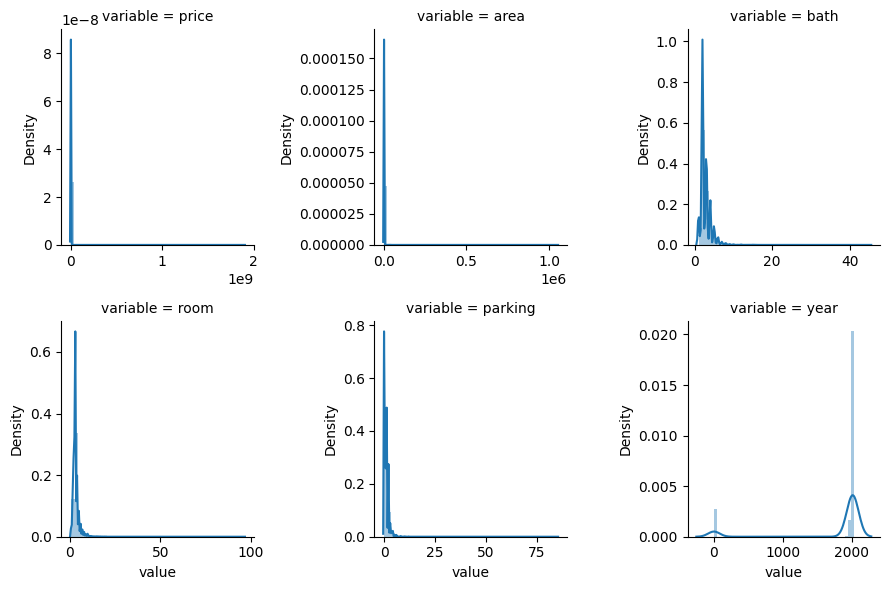

In [14]:
f = pd.melt(df_num.iloc[:,:-1], value_vars=df_num.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

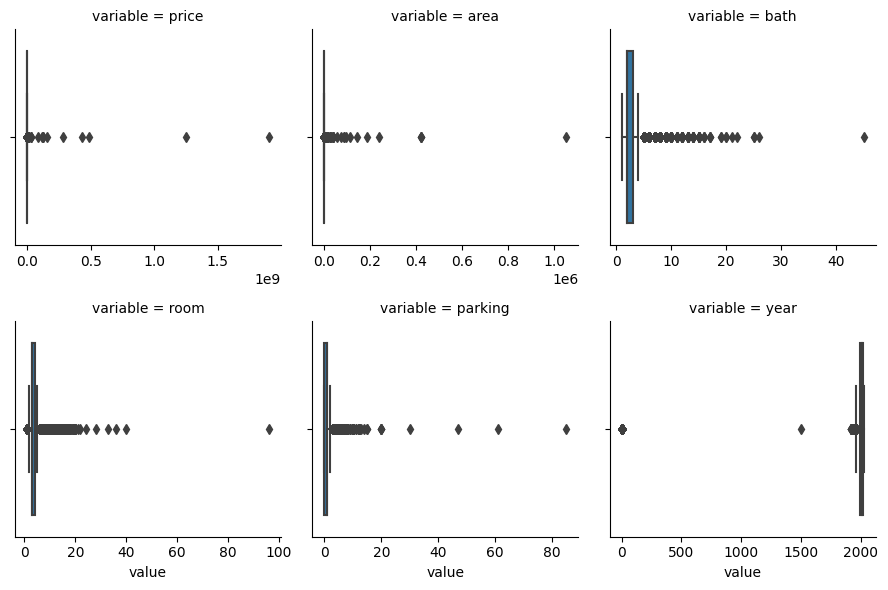

In [15]:
f = pd.melt(df_num.iloc[:,:-1], value_vars=df_num.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

As we can appreciate, all variables have outliers. 

In [16]:
def outliers(column, df_outlier):
    Q1 = df_outlier[column].dropna().quantile(0.25)
    Q3 = df_outlier[column].dropna().quantile(0.75)
    IQR = Q3 - Q1

    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    return lower_whisker, upper_whisker

In [17]:
#lower_area, upper_area = outliers('area', df_num)
#lower_area, upper_area

In [18]:
threshold = 500
mask = (df_num['area'] < threshold)
df_num = df_num[mask]
df_num.shape

(20406, 7)

## Outliers Casa & Departamento

In [19]:
mask = df_num['property_type'] == 'Departamento'
df_departamento = df_num.loc[mask]
mask = df_num['property_type'] == 'Casa'
df_casa = df_num.loc[mask]
print(df_departamento.shape, df_casa.shape)

(15827, 7) (4579, 7)


### Departamento

#### Outliers Area

In [20]:
lower_darea, upper_darea = outliers('area', df_departamento)
lower_darea, upper_darea

(-40.5, 259.5)

In [21]:
# mask = df_departamento['area'] > upper_darea
# df_departamento.loc[mask]

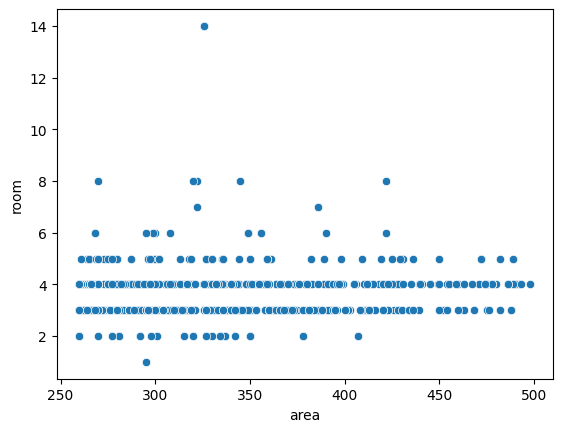

In [22]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.scatterplot(data=df_departamento.loc[mask], x='area', y='room')
plt.show()

In [23]:
mask = (df_departamento['area'] > upper_darea)
lower_room, upper_room = outliers('room', df_departamento[mask])
lower_room, upper_room

(1.5, 5.5)

In [24]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['room'] <= 2)|(df_departamento['room'] >= 6))
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(15781, 7)

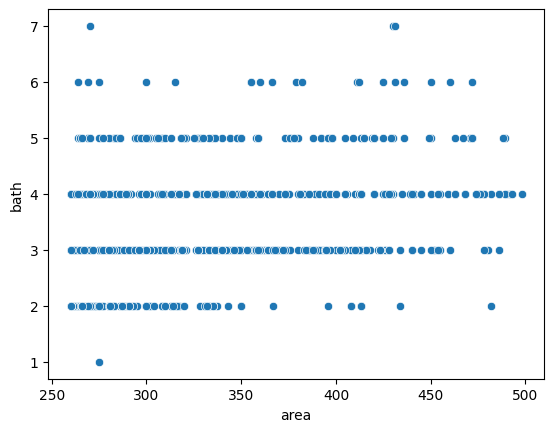

In [25]:
mask = df_departamento['area'] > upper_darea
plt.figure()
sns.scatterplot(data=df_departamento.loc[mask], x='area', y='bath')
plt.show()

In [26]:
mask = (df_departamento['area'] > upper_darea) & ((df_departamento['bath'] <= 1)|(df_departamento['bath'] >= 6))
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(15758, 7)

#### Outliers Room & Bath

In [27]:
lower_droom, upper_droom = outliers('room', df_departamento)
lower_droom, upper_droom

(0.5, 4.5)

In [28]:
mask = df_departamento['room'] < 5
df_departamento = df_departamento[mask]
df_departamento.shape

(15502, 7)

In [29]:
lower_dbath, upper_dbath = outliers('bath', df_departamento)
lower_dbath, upper_dbath

(0.5, 4.5)

In [30]:
mask = df_departamento['bath'] < 5
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(15300, 7)

#### Bath < Room

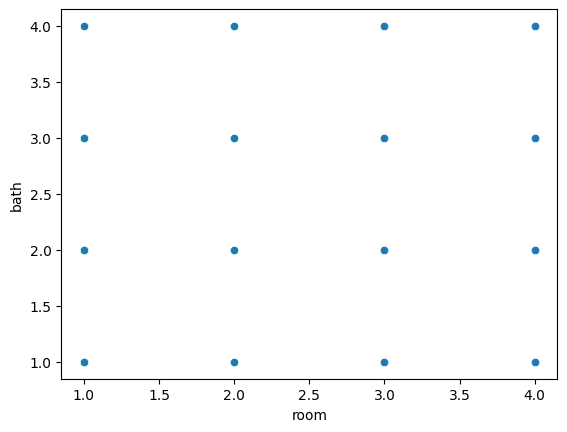

In [31]:
plt.figure()
sns.scatterplot(data=df_departamento, x='room', y='bath')
plt.show()

In [32]:
mask = df_departamento['bath'] > df_departamento['room']
df_departamento = df_departamento.loc[~mask]
df_departamento.shape

(14123, 7)

#### Outlier Parking

In [33]:
lower_dparking, upper_dparking = outliers('parking', df_departamento)
lower_dparking, upper_dparking

(-1.5, 2.5)

In [34]:
mask = df_departamento['parking'] <= 2
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(13824, 7)

In [35]:
df_departamento['parking'] = df_departamento['parking'].replace(2, 1)
df_departamento.shape

(13824, 7)

In [36]:
df_departamento['parking'].value_counts()

0    7600
1    6224
Name: parking, dtype: int64

#### Outlier Year

In [37]:
df_departamento.loc[df_departamento['year'] == 0]

,price,area,bath,room,parking,year,property_type
51,130189,70,2,3,1,0,Departamento
222,595000,277,4,4,0,0,Departamento
229,180941,87,2,2,1,0,Departamento
317,20000,92,2,3,0,0,Departamento
357,36486,132,2,4,1,0,Departamento
...,...,...,...,...,...,...,...
26702,40446,73,1,2,0,0,Departamento
26719,62432,64,2,2,0,0,Departamento
26811,102686,100,2,2,0,0,Departamento
26895,73000,71,2,3,0,0,Departamento


In [38]:
mask = (df_departamento['year'] != 0) & (df_departamento['year'] != 2023) 
new_year = int(df_departamento.loc[mask, 'year'].median())
df_departamento['year'] = df_departamento['year'].replace(0, new_year)
df_departamento.shape

(13824, 7)

#### Outliers Price (REVISAR CON EDGAR)

In [39]:
lower_dprice, upper_dprice = outliers('price', df_departamento)
lower_dprice, upper_dprice

(-95000.0, 425000.0)

In [40]:
df_departamento.price.min()

0

In [41]:
df_departamento.price.max()

282702702

In [42]:
mask = df_departamento['price'] > 250000
df_departamento = df_departamento.loc[~mask]

In [43]:
mask = df_departamento['price'] > 100
df_departamento = df_departamento.loc[mask]
df_departamento.shape

(10909, 7)

### Casa

#### Outliers Area

In [44]:
lower_carea, upper_carea = outliers('area', df_casa)
lower_carea, upper_carea

(-91.25, 534.75)

In [45]:
mask = df_casa['area'] > upper_carea
df_casa.loc[mask]

,price,area,bath,room,parking,year,property_type


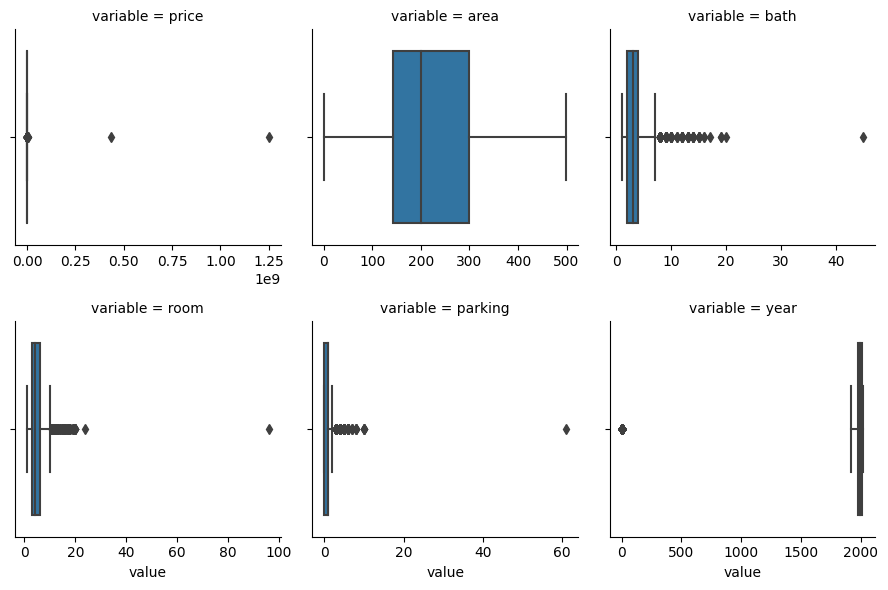

In [46]:
f = pd.melt(df_casa.iloc[:,:-1], value_vars=df_num.columns[:-1])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

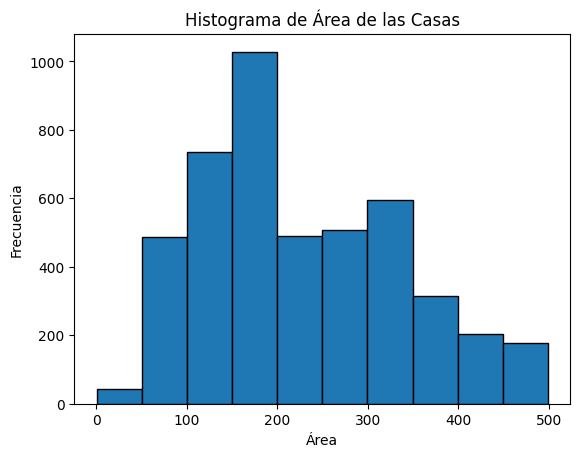

In [47]:
plt.hist(df_casa["area"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Área")
plt.ylabel("Frecuencia")
plt.title("Histograma de Área de las Casas")

# Mostrar el gráfico
plt.show()


In [48]:
mask = df_casa['area'] < 30
df_casa = df_casa.loc[~mask]

In [49]:
#mask = df_casa['area'] > upper_carea
#plt.figure()
#sns.scatterplot(data=df_casa.loc[mask], x='area', y='room')
#plt.show()

In [50]:
#mask = (df_departamento['area'] > upper_darea)
#lower_room, upper_room = outliers('room', df_departamento[mask])
#lower_room, upper_room

In [51]:
#mask = (df_departamento['area'] > upper_darea) & ((df_departamento['room'] <= 2)|(df_departamento['room'] >= 6))
#df_departamento = df_departamento.loc[~mask]
#df_departamento.shape

In [52]:
#mask = df_departamento['area'] > upper_darea
#plt.figure()
#sns.scatterplot(data=df_departamento.loc[mask], x='area', y='bath')
#plt.show()

In [53]:
#mask = (df_departamento['area'] > upper_darea) & ((df_departamento['bath'] <= 1)|(df_departamento['bath'] >= 6))
#df_departamento = df_departamento.loc[~mask]
#df_departamento.shape

#### Outliers Room & Bath

In [54]:
lower_croom, upper_croom = outliers('room', df_casa)
lower_croom, upper_croom

(-1.5, 10.5)

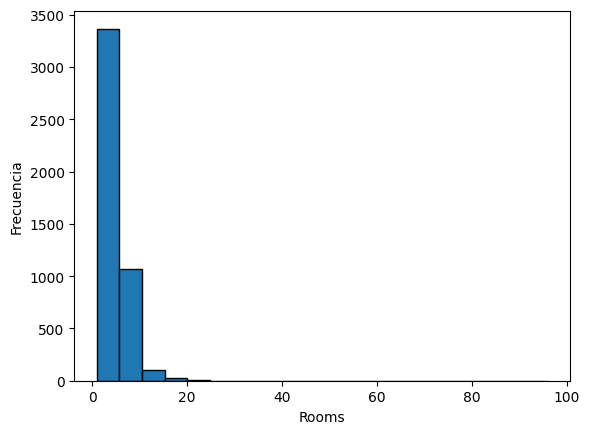

In [55]:
plt.hist(df_casa["room"], edgecolor='k', bins= 20)

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [56]:
mask = df_casa['room'] > 10
df_casa = df_casa[~mask]
df_casa.shape

(4433, 7)

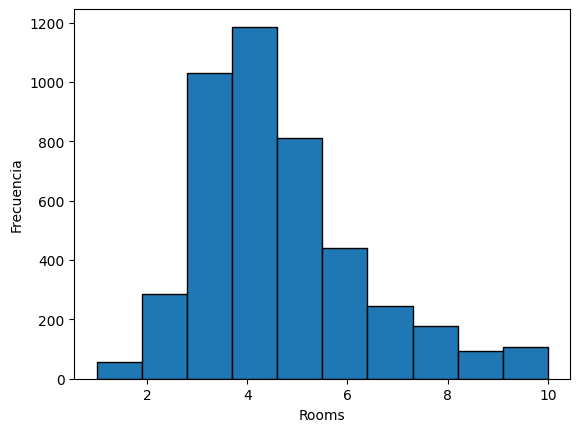

In [57]:
plt.hist(df_casa["room"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Rooms")
plt.ylabel("Frecuencia")
plt.show()


In [58]:
#id_hotel = df[df["room"] >10]['description'].apply(lambda x: x.lower()).str.extract('(hotel)').dropna().index
#df.loc[id_hotel]

In [59]:
lower_cbath, upper_cbath = outliers('bath', df_casa)
lower_cbath, upper_cbath

(-1.0, 7.0)

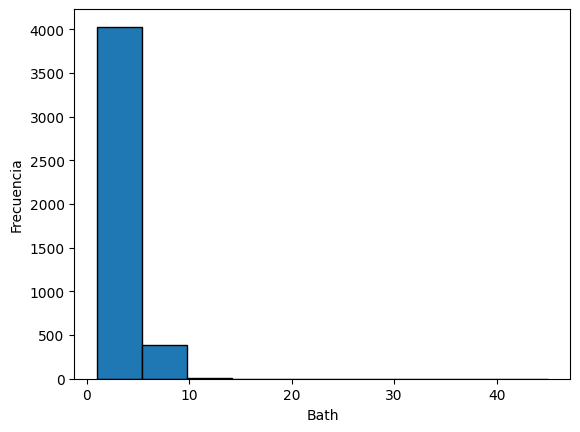

In [60]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


In [61]:
mask = df_casa['bath'] > 7
df_casa = df_casa[~mask]
df_casa.shape

(4366, 7)

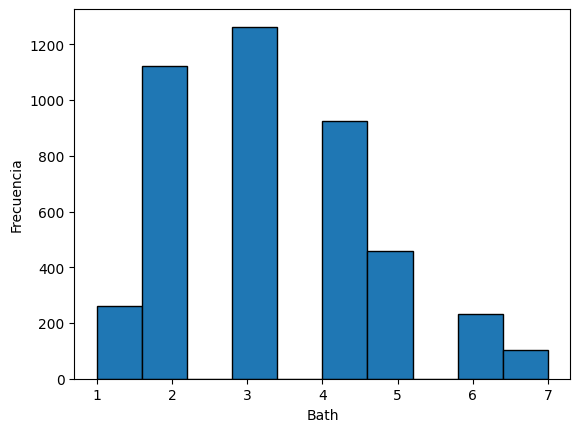

In [62]:
plt.hist(df_casa["bath"], edgecolor='k')

# Configurar etiquetas y título
plt.xlabel("Bath")
plt.ylabel("Frecuencia")
plt.show()


#### Bath < Room

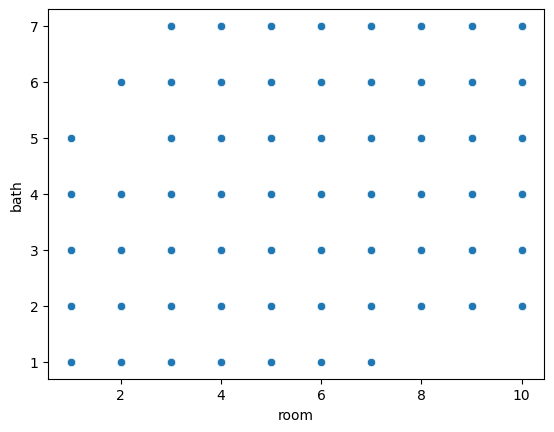

In [63]:
plt.figure()
sns.scatterplot(data=df_casa, x='room', y='bath')
plt.show()

In [64]:
mask = df_casa['bath'] > df_casa['room']
df_casa = df_casa.loc[~mask]
df_casa.shape

(3987, 7)

#### Outlier Parking

In [65]:
lower_cparking, upper_cparking = outliers('parking', df_casa)
lower_cparking, upper_cparking

(-1.5, 2.5)

In [66]:
mask = df_casa['parking'] <= 2
df_casa = df_casa.loc[mask]


In [67]:
df_casa['parking'] = df_casa['parking'].replace(2, 1)
df_casa.shape

(3722, 7)

In [68]:
df_casa['parking'].value_counts()

1    2012
0    1710
Name: parking, dtype: int64

#### Outlier Year

In [69]:
df_casa.loc[df_casa['year'] == 0]

,price,area,bath,room,parking,year,property_type
236,205000,160,2,4,1,0,Casa
641,178378,338,2,4,0,0,Casa
1132,120000,120,2,4,1,0,Casa
1428,150000,53,2,3,0,0,Casa
1857,280000,360,5,6,1,0,Casa
...,...,...,...,...,...,...,...
26340,280000,270,3,4,0,0,Casa
26351,267800,200,3,6,0,0,Casa
26367,80000,140,3,4,1,0,Casa
26368,60000,120,1,2,0,0,Casa


In [70]:
df_casa["year"].value_counts()

0       617
2023    220
2013    172
2003    153
1993    139
       ... 
1948      1
1951      1
1932      1
1947      1
1923      1
Name: year, Length: 85, dtype: int64

In [71]:
mask = (df_casa['year'] != 0) & (df_casa['year'] != 2023) 
new_year = int(df_casa.loc[mask, 'year'].median())
df_casa['year'] = df_casa['year'].replace(0, new_year)
df_casa.shape

(3722, 7)

#### Outliers Price (REVISAR CON EDGAR)

In [72]:
lower_cprice, upper_cprice = outliers('price', df_casa)
lower_cprice, upper_cprice

(-240000.0, 760000.0)

In [73]:
mask = df_casa['price'] > 300000
df_casa = df_casa.loc[~mask]

In [74]:
mask = df_casa['price'] > 100
df_casa = df_casa.loc[mask]
df_casa.shape

(2409, 7)